ARIMA(0, 0, 0) RMSE=6.540
ARIMA(0, 0, 1) RMSE=6.709
ARIMA(0, 0, 2) RMSE=7.165
ARIMA(0, 1, 0) RMSE=10.592
ARIMA(0, 1, 1) RMSE=7.179
ARIMA(0, 1, 2) RMSE=7.270
ARIMA(1, 0, 0) RMSE=6.826
ARIMA(1, 0, 1) RMSE=7.093
ARIMA(1, 0, 2) RMSE=6.077
ARIMA(1, 1, 0) RMSE=8.389
ARIMA(1, 1, 1) RMSE=7.350
ARIMA(1, 1, 2) RMSE=7.780
ARIMA(2, 0, 0) RMSE=7.050
ARIMA(2, 0, 1) RMSE=6.842
ARIMA(2, 0, 2) RMSE=6.788
ARIMA(2, 1, 0) RMSE=7.311
ARIMA(2, 1, 1) RMSE=7.553
ARIMA(2, 1, 2) RMSE=7.811
Best ARIMA(1, 0, 2) RMSE=6.077


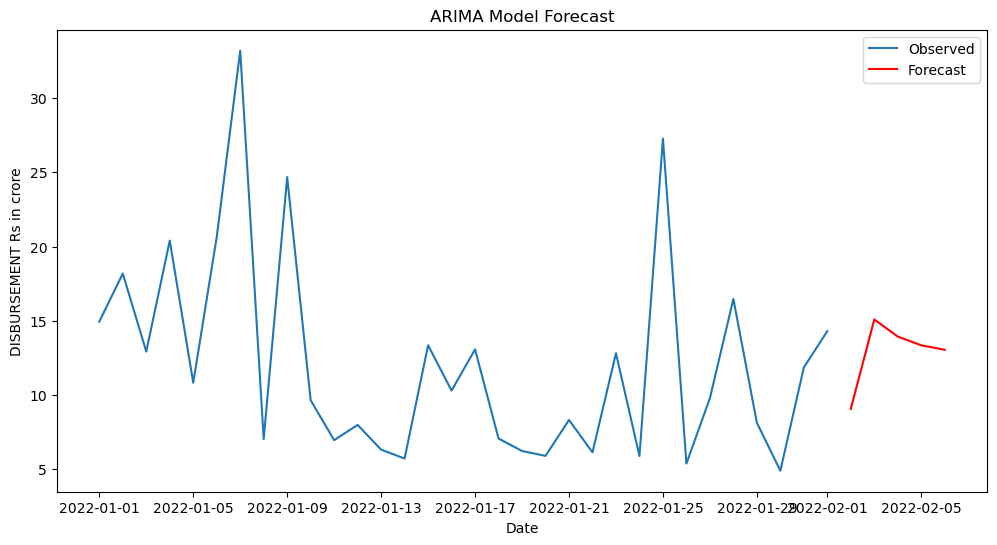

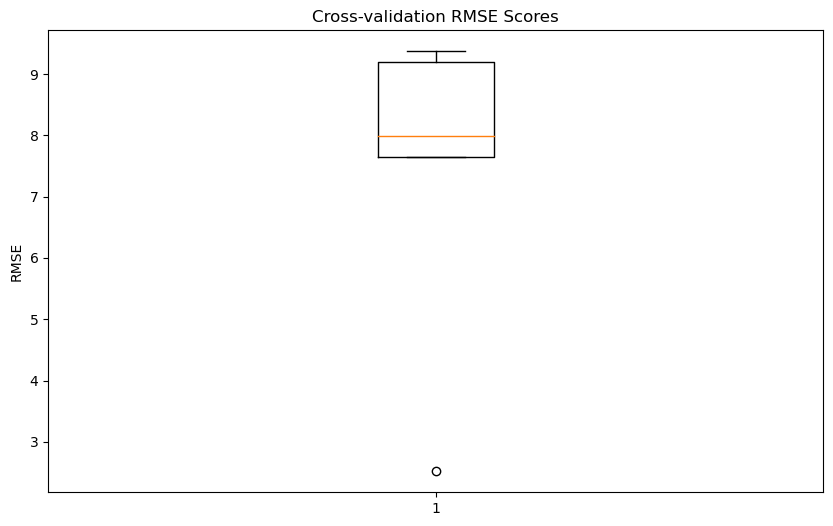

Cross-validation RMSE scores: [9.371551008717832, 9.194635609261498, 7.646586965972368, 7.994030967920235, 2.5191961901591755]
Mean CV RMSE: 7.345


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tools.eval_measures import rmse
import warnings

# Read the CSV file
df = pd.read_csv("C:\\Users\\ankit\\Downloads\\branch-wise-oper-perf-2021-22.csv")

# Create a synthetic time series
time_series = pd.Series(df['DISBURSEMENT Rs in crore'].values, index=pd.date_range(start='2022-01-01', periods=len(df), freq='D'))

# Function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate RMSE
    error = rmse(test, predictions)
    return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

# Evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
warnings.filterwarnings("ignore")
best_order = evaluate_models(time_series.values, p_values, d_values, q_values)

# Fit and forecast
model = ARIMA(time_series, order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=5)  # Forecast next 5 days

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(time_series, label='Observed')
plt.plot(pd.date_range(start=time_series.index[-1] + pd.Timedelta(days=1), periods=5, freq='D'), forecast, color='red', label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('DISBURSEMENT Rs in crore')
plt.legend()
plt.show()

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_index, test_index in tscv.split(time_series):
    cv_train, cv_test = time_series.iloc[train_index], time_series.iloc[test_index]
    model = ARIMA(cv_train, order=best_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(cv_test))
    error = rmse(cv_test, forecast)
    cv_scores.append(error)

# Plot cross-validation results
plt.figure(figsize=(10,6))
plt.boxplot(cv_scores)
plt.title('Cross-validation RMSE Scores')
plt.ylabel('RMSE')
plt.show()

print(f"Cross-validation RMSE scores: {cv_scores}")
print(f"Mean CV RMSE: {np.mean(cv_scores):.3f}")